# Project 1: Digit Classification with KNN and Naive Bayes
## Sho Ohata - W207 Section 1

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [46]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

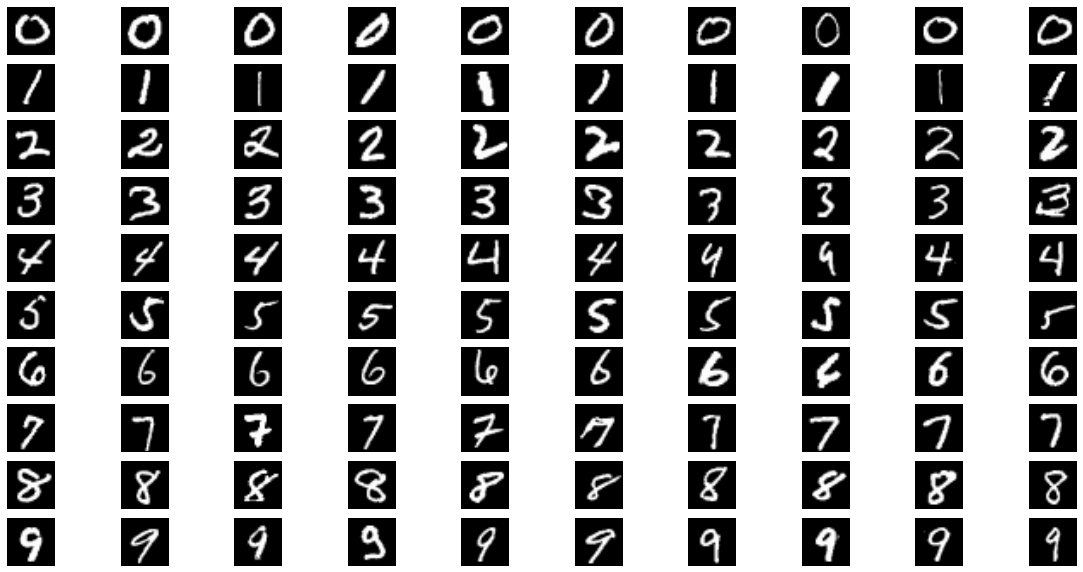

In [4]:
def P1(num_examples=10):
### STUDENT START ###

##Find indices of each digit and create dictionary for the locations
    index = {}
    for a in range(num_examples):
        index[a] = np.where(Y ==a )[0][0:num_examples]

    plt.figure(figsize=(20, 10))
    plt.rc('image', cmap='gray')

    ##Initiate loop to plot various examples
    for a in range(num_examples):
        for b in range(num_examples):
            ax = plt.subplot(num_examples, num_examples, (a * num_examples + b + 1))
            
            # Turn off tick marks to keep things clean.
            plt.setp(ax, xticks=(), yticks=())
            
            #Plot using reshape function to make vector into 28x28 matrix
            plt.imshow(np.reshape(X[index[a][b]:index[a][b]+1,], (28,28)))

    plt.show()
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [3]:
def P2(k_values):
### STUDENT START ###
    for i in range(len(k_values)):
        neigh = KNeighborsClassifier(n_neighbors=k_values[i])
        neigh.fit(mini_train_data, mini_train_labels)
        preds = neigh.predict(dev_data)
    
        print "k=", k_values[i], "; accuracy:", np.mean(preds == dev_labels)
        
        if k_values[i] == 1:
            preds_k1 = preds
    
    print("\nPrecision, recall, and F1 for each label:")
    print("\n")
    print(classification_report(dev_labels, preds_k1))
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

k= 1 ; accuracy: 0.888
k= 3 ; accuracy: 0.878
k= 5 ; accuracy: 0.869
k= 7 ; accuracy: 0.865
k= 9 ; accuracy: 0.863

Precision, recall, and F1 for each label:


             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



**ANSWER: Both the digits 9 and 3 seems to have some difficulty as can be seen by the precision and recall values. Overall the F1 score seems to indicate that digit 9 has the most difficulty.**

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [12]:
def P3(train_sizes, accuracies):
### STUDENT START ###
    ## Fit KNN on dev dataset.
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(dev_data, dev_labels)
    
    ##Start loop and collect calculation time details.
    for a in range(len(train_sizes)):
        start = time.time()
        train = test_data[:train_sizes[a]]
        labels = test_labels[:train_sizes[a]]
        preds = neigh.predict(train)
        elapsed = (time.time() - start)
        
        print "Training Set Size = ", train_sizes[a], "; accuracy = ", np.mean(preds==labels), "; computation time ", elapsed
        accuracies.append(np.mean(preds == labels))
        
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Training Set Size =  100 ; accuracy =  0.92 ; computation time  0.149999856949
Training Set Size =  200 ; accuracy =  0.91 ; computation time  0.276999950409
Training Set Size =  400 ; accuracy =  0.8875 ; computation time  0.575000047684
Training Set Size =  800 ; accuracy =  0.8975 ; computation time  1.10400009155
Training Set Size =  1600 ; accuracy =  0.8925 ; computation time  2.16899991035
Training Set Size =  3200 ; accuracy =  0.8953125 ; computation time  4.2619998455
Training Set Size =  6400 ; accuracy =  0.88859375 ; computation time  8.69499993324
Training Set Size =  12800 ; accuracy =  0.888222222222 ; computation time  12.1870000362
Training Set Size =  25000 ; accuracy =  0.888222222222 ; computation time  12.0659999847


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [239]:
def P4():

### STUDENT START ###
    ##Plot was used to visualize the relationship
    ##plt.scatter(train_sizes, accuracies)
    clf = LinearRegression()
    lm = clf.fit(np.array(train_sizes)[:,np.newaxis], accuracies)
    lm_log = clf.fit(np.log(train_sizes)[:,np.newaxis], accuracies)
    
    print 'Accuracy of the model using a linear model is %3.2f' %lm.predict(60000)
    print '\nAccuracy of the model using a linear model after a logarithmic transformation is %3.2f' %lm_log.predict(np.log(60000))
### STUDENT END ###

P4()

Accuracy of the model using a linear model is -277.57

Accuracy of the model using a linear model after a logarithmic transformation is 0.88


**ANSWER: Plot of the relationship between training size and accuracy shows that the relationship is non-linear. So in this case applying a simple regression does not capture the relationship between training size and accuracy of the model as can be seen by the predicted accuracy which does not make sense. A logarithmic transformation will help address this non-linear nature and produces a more sensible accuracy of 0.88. **

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Normalized confusion matrix
[[ 0.98  0.    0.    0.    0.    0.    0.02  0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.04  0.04  0.79  0.04  0.    0.    0.    0.04  0.03  0.02]
 [ 0.01  0.    0.    0.87  0.    0.03  0.    0.03  0.01  0.03]
 [ 0.    0.02  0.    0.    0.82  0.    0.03  0.    0.    0.13]
 [ 0.02  0.    0.    0.1   0.    0.84  0.    0.01  0.01  0.02]
 [ 0.01  0.01  0.01  0.    0.01  0.    0.96  0.    0.    0.  ]
 [ 0.01  0.04  0.    0.01  0.01  0.    0.    0.92  0.    0.02]
 [ 0.    0.02  0.    0.05  0.    0.02  0.01  0.    0.88  0.02]
 [ 0.01  0.    0.    0.03  0.08  0.01  0.    0.05  0.    0.82]]

Some Examples of failed classifications


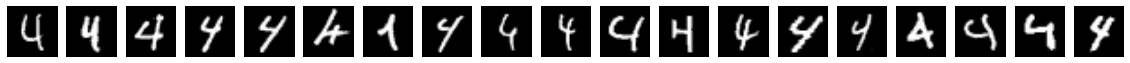

In [36]:
def P5():

### STUDENT START ###
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(mini_train_data, mini_train_labels)
    pred = neigh.predict(dev_data)
    cm = confusion_matrix(dev_labels, pred)
    np.set_printoptions(precision = 2)
    cm_normalized = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    
    ##From the confusion matrix the digit 4 seems to have a lot of trouble.
    index = np.where((dev_labels == 4) & (dev_labels != pred))[0]
    
    plt.figure(figsize=(20, 10))
    plt.rc('image', cmap='gray')

    print('\nSome Examples of failed classifications')
    
    for b in range(len(index)):
        ax = plt.subplot(1, len(index), b + 1)
        # Turn off tick marks to keep things clean.
        plt.setp(ax, xticks=(), yticks=())
        
        plt.imshow(np.reshape(dev_data[index[b]:index[b]+1,], (28,28)))

    plt.show()
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [236]:
##Gaussian distance as defined on Gaussian blur wiki page.
##https://en.wikipedia.org/wiki/Gaussian_blur#Mechanics

def gauss_distance(center, pixel, sigma):
    x = (pixel[0] - center[0]) ** 2
    y = (pixel[1] - center[1]) ** 2
    
    return np.exp(-(x + y) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)

def gaussian_blur(data_input, sigma = 2):
    rows, cols = data_input.shape    
    blurred_matrix = np.zeros((rows, cols))
    
    ##Ignoring edge cases
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            neighbors = np.concatenate((data_input[i - 1,(j - 1):(j + 2)], data_input[i + 1,(j - 1):(j + 2)], 
                                        data_input[i,(j - 1):(j + 2)]), axis = 0)
            weights = [gauss_distance((i, j), (x, y), sigma) for x in range(i - 1, i + 2) for y in xrange(j - 1, j + 2)]
            weights /= sum(weights)

            blurred_matrix[i,j] = sum(neighbors * weights)
   
    return blurred_matrix

In [238]:
def P6():
### STUDENT START ###
    Gaussian_dev = np.zeros(dev_data.shape)
    for a in range(dev_data.shape[0]):
        Gaussian_dev[a:a+1,] = np.reshape(gaussian_blur(np.reshape(dev_data[a:a + 1,],(28,28))),(1,784))
        
    Gaussian_mini_train = np.zeros(mini_train_data.shape)
    for a in range(mini_train_data.shape[0]):
        Gaussian_mini_train[a:a+1,] = np.reshape(gaussian_blur(np.reshape(mini_train_data[a:a + 1,],(28,28))),(1,784))
    
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(Gaussian_mini_train, mini_train_labels)
    pred = neigh.predict(dev_data)
    print 'Preprocess the training data but not the dev data. Accuracy:', np.mean(pred == dev_labels)
    
    neigh.fit(mini_train_data, mini_train_labels)
    pred = neigh.predict(Gaussian_dev)
    print '\nPreprocess the dev data but not the training data. Accuracy:', np.mean(pred == dev_labels)
    
    neigh.fit(Gaussian_mini_train, mini_train_labels)
    pred = neigh.predict(Gaussian_dev)
    print '\nPreprocess both the dev and training data. Accuracy:', np.mean(pred == dev_labels)
### STUDENT END ###

P6()

Preprocess the training data but not the dev data. Accuracy: 0.895

Preprocess the dev data but not the training data. Accuracy: 0.864

Preprocess both the dev and training data. Accuracy: 0.903


**ANSWER: As can be seen by the results, preprocessing both the dev and training data first seems to yield the best result.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [55]:
def P7():

### STUDENT START ###
    bern = BernoulliNB(binarize = 0.6)
    bern.fit(mini_train_data, mini_train_labels)
    print 'bernoulli accuracy: %3.2f' %bern.score(dev_data, dev_labels)
    
    mini_train_data_mult = np.where(mini_train_data > 0.6, 2, np.where(mini_train_data > 0.2, 1, 0))
    dev_data_mult = np.where(dev_data > 0.6, 2, np.where(dev_data > 0.2, 1, 0))
    mult = MultinomialNB()
    mult.fit(np.floor(mini_train_data_mult), mini_train_labels)
    print 'multinomial accuracy: %3.2f' %mult.score(dev_data_mult, dev_labels)
    
### STUDENT END ###

P7()

bernoulli accuracy: 0.81
multinomial accuracy: 0.80


**ANSWER: The muli-class version does not improve the accuracy by much. This is likely due to the fact that digit classification is not driven by the shade of the pixel so adding additional classifiers will not improve the classification.**

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [74]:
def P8(alphas):

### STUDENT START ###

    bern = BernoulliNB(binarize = 0.6)
    clf = GridSearchCV(bern, alphas)
    clf.fit(mini_train_data, mini_train_labels)
    return clf
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

In [76]:
print nb.best_params_

print nb.grid_scores_['alpha' == 0]

{'alpha': 0.01}
mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}


**ANSWER: The best value for alpha is 0.01, and the accuracy for when alpha = 0 is 0.09. This result is expected since the mini training dataset is fairly small there are many instances in the training set where there are no other examples which makes the conditional probability zero. By including the smoothing parameter this issue is mitigated.**

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

Initial Gaussian Naive Bayes accuracy: 0.62

[[  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 ..., 
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]]

Gaussian Naive Bayes accuracy after sigma is modified: 0.80


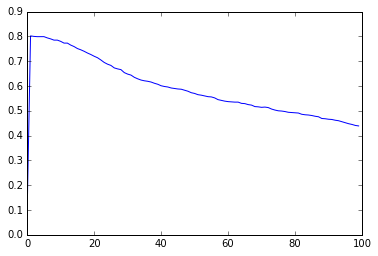

In [145]:
def P9():

### STUDENT END ###
    gau = GaussianNB()
    gau.fit(mini_train_data, mini_train_labels)
    print 'Initial Gaussian Naive Bayes accuracy: %3.2f' %gau.score(dev_data, dev_labels)
    print '\n', gau.sigma_
    
    ##Since the sigma is set at values very close to zero various values will be tested and plotted to see if 
    ##there is a swee spot for a sigma value.
    gau_sig = GaussianNB()
    gau_sig.fit(mini_train_data, mini_train_labels)
    score=[]
    for a in np.arange(0,100,1):
        gau_sig.sigma_ = np.reshape(np.repeat(a,784000),(1000,784))
        score.append(gau_sig.score(dev_data, dev_labels))
    plt.plot(np.arange(0,100,1),np.array(score))
    
    ##From the graph it seems like anything larger than 0 gives a good accuracy value.
    gau_sig.sigma_ = np.reshape(np.repeat(2,784000),(1000,784))
    print '\nGaussian Naive Bayes accuracy after sigma is modified: %3.2f' %gau_sig.score(dev_data, dev_labels)
    
### STUDENT END ###

gnb = P9()

**ANSWER: The sigma that is established in the initial Gaussian Naive Bayes is estimated to be approximately zero. The sample variance for this dataset is clearly not zero and thus providing some meaningful sigma value yields a better accuracy model.**

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

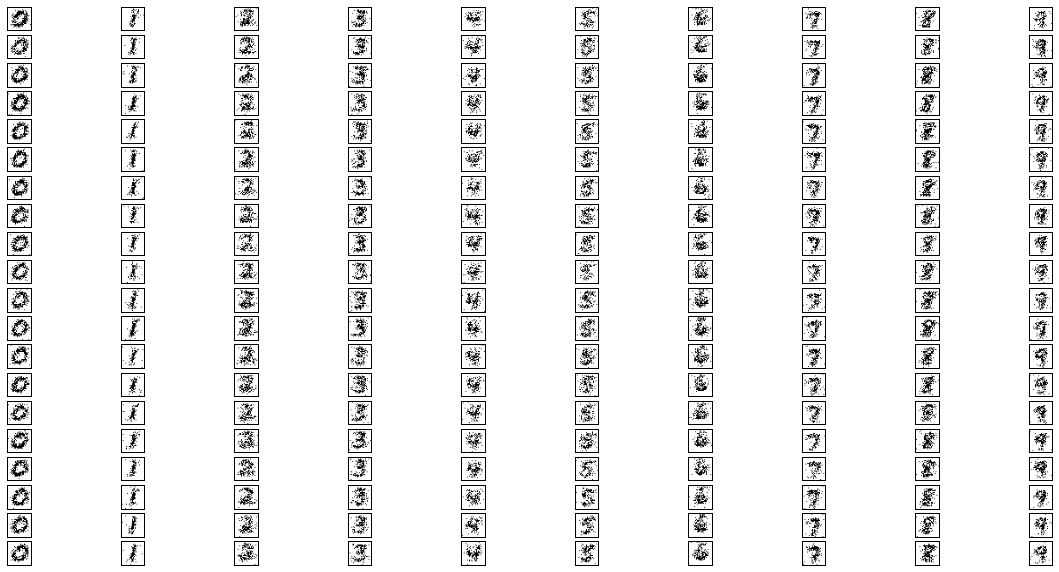

In [35]:
def P10(num_examples):

### STUDENT START ###
    bern = BernoulliNB(binarize=0.3)
    bern.fit(dev_data, dev_labels)
    
    plt.figure(figsize=(20, 10))
    plt.rc('image', cmap='gray')

    for a in range(10):
        for b in range(num_examples):
            ax = plt.subplot(20, 10, (b * 10 + a + 1))
            # Turn off tick marks to keep things clean.
            plt.setp(ax, xticks=(), yticks=())
        
            plt.imshow(np.reshape(np.where((np.exp(bern.feature_log_prob_[a]) < np.random.rand(784))==True,1,0),(28,28)))

    plt.show()
### STUDENT END ###

P10(20)

**ANSWER: The generated digits are okay looking. They certainly capture a good amount of features for most of them, but many of them look quite blurry. Some of the simple digits like 1 and zero look fairly well but the other digits fall a bit short.**

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [305]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    bern = BernoulliNB(alpha = 0.01, binarize=0.3)
    bern.fit(mini_train_data, mini_train_labels)
    
    for a in range(bern.predict_proba(dev_data).shape[0]):
        max_post = np.max(bern.predict_proba(dev_data)[a:a + 1,:])
        for b in range(len(buckets) - 1):
            if np.logical_and(max_post > buckets[b], max_post <= buckets[b+1]) == True:
                total[b+1] += 1
                if np.argmax(bern.predict_proba(dev_data)[a:a+1,:]) == dev_labels[a]:
                    correct[b+1] += 1
            elif max_post < buckets[0]: 
                total[0] += 1
                if np.argmax(bern.predict_proba(dev_data)[a:a+1,:]) == dev_labels[a]:
                    correct[0] += 1

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = 1.0 * correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =  16    accuracy = 0.500
p(pred) <= 0.9000000000000    total =  41    accuracy = 0.341
p(pred) <= 0.9990000000000    total =  75    accuracy = 0.400
p(pred) <= 0.9999900000000    total =  66    accuracy = 0.667
p(pred) <= 0.9999999000000    total =  58    accuracy = 0.603
p(pred) <= 0.9999999990000    total =  62    accuracy = 0.710
p(pred) <= 0.9999999999900    total =  60    accuracy = 0.833
p(pred) <= 0.9999999999999    total =  62    accuracy = 0.839
p(pred) <= 1.0000000000000    total = 574    accuracy = 0.962


**ANSWER: As higher the posterior becomes the accuracy of the model increases. However, despite the level of posterior of 0.9 the accuracy of the model is fairly low. While this is not poorly calibrated this model is weakly calibrated as can be seen by the posterior accuracy pairings.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [16]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()